---
## Step 0: Load The Data

Training...
EPOCH 1    Validation Accuracy = 0.552
EPOCH 2    Validation Accuracy = 0.730
EPOCH 3    Validation Accuracy = 0.795
EPOCH 4    Validation Accuracy = 0.826
EPOCH 5    Validation Accuracy = 0.840
EPOCH 6    Validation Accuracy = 0.857
EPOCH 7    Validation Accuracy = 0.857
EPOCH 8    Validation Accuracy = 0.879
EPOCH 9    Validation Accuracy = 0.884
EPOCH 10    Validation Accuracy = 0.885


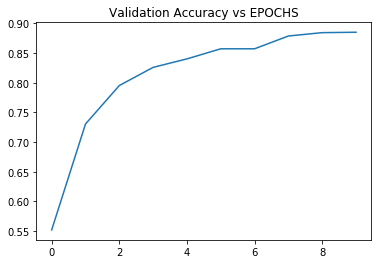

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle
import random
%matplotlib inline

# Load pickled data
# Pickle is used to serialize the data so that it can be saved to a disk

training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
#print(train.keys())

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


####################################################################################################################
LEARN_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 10
KEEP_PROB = 0.5

#Number of labels should be same as number of input images
assert(len(X_train) == len(y_train))
n_train = len(X_train)

assert(len(X_valid) == len(y_valid))
n_valid = len(X_valid)

assert(len(X_test) == len(y_test))
n_test = len(X_test)

# Image Shape
image_shape = X_train[0].shape

# Number of classes / labels
n_classes = len(np.unique(y_train))


def readcsv(file):
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile)
        label_dict = {row['ClassId']:row['SignName'] for row in reader}
        return label_dict

count, label = np.unique(y_train, return_counts=True)
label_dict = readcsv('signnames.csv')

def get_label_name(label_no):
    return label_dict[label_no]


X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
X_train_gry = np.sum(X_train_shuffle/3, axis=3, keepdims=True)
X_train_shuffle_normalized = (X_train_gry - 127.5) / 255
X_train, y_train = X_train_shuffle_normalized, y_train_shuffle

#Shuffle, Normalize Validation Set
X_valid_shuffle, y_valid_shuffle = shuffle(X_valid, y_valid)
X_valid_gry = np.sum(X_valid_shuffle/3, axis=3, keepdims=True)
X_valid_shuffle_normalized = (X_valid_gry - 127.5) / 255
X_valid, y_valid = X_valid_shuffle_normalized, y_valid_shuffle

#Shuffle, Normalize Test Set
X_test_shuffle, y_test_shuffle = shuffle(X_test, y_test)
X_test_gry = np.sum(X_test_shuffle/3, axis=3, keepdims=True)
X_test_shuffle_normalized = (X_test_gry - 127.5) / 255
X_test, y_test = X_test_shuffle_normalized, y_test_shuffle

####################################################################################################################
# Conv --> MaxPool --> Conv --> MaxPool --> FC1 --> FC2 --> o/p
def NN_LeNet(inputs):
    """
    LeNet Architecture
    CN1 --> P1 --> CN2 --> P2 --> Flatten --> FC1 --> FC2 --> O/P
    Each step after CN & FC follows by an activation layer
    Here are the dimensions of LeNet

    Input : 32, 32, 3 #3 channels for RGB. If you are using Gray scale, then have this as 1
    Layer1 : CN1 Output : 28, 28, 6
    Layer2 : P1 Output  : 14, 14, 6
    Layer3 : CN2 Output : 10, 10, 16
    Layer4 : P2 Output  : 5, 5, 16
    Layer5 : FC1 Output : 120
    Layer6 : FC2 Output : 84
    Layer7 : Logits     : 43 #43 different classes in German Traffic Sign dataset
    """

    #Defining weights, bias and outputs for each Layer
    mu = 0 #Mean of the variables in the random distribution
    sigma = 0.1 #Variance is 0.1
    
    #Layer1 - Convolution - Output Size : 28, 28, 6
    #After conversion to Gray scale, the dimension size is 1 instead of 3 (RGB)
    w_layer1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    b_layer1 = tf.Variable(tf.zeros(6))
    conv_layer1 = tf.nn.conv2d(inputs, w_layer1, strides=[1,1,1,1], padding='VALID') + b_layer1
    act_layer1 = tf.nn.relu(conv_layer1)
    #drop_layer1 = tf.nn.dropout(act_layer1, KEEP_PROB)

    #Layer2 - Max Pooling - Output Size : 14, 14, 6
    pool_layer2 = tf.nn.max_pool(act_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer3 - Convolution - Output Size : 10, 10, 16 ==> 16 filters, size is (W + 2P - F)/S + 1
    w_layer3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b_layer3 = tf.Variable(tf.zeros(16))
    conv_layer3 = tf.nn.conv2d(pool_layer2, w_layer3, strides=[1, 1, 1, 1], padding='VALID') + b_layer3
    act_layer3 = tf.nn.relu(conv_layer3)
    #drop_layer3 = tf.nn.dropout(act_layer3, KEEP_PROB)

    #Layer4 - Max Pooling - Output Size : 5, 5, 16
    pool_layer4 = tf.nn.max_pool(act_layer3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatenning as next layers are fully connected
    flatten_vect = tf.contrib.layers.flatten(pool_layer4)

    #Layer5 - Fully Connected - Output = 120. Input dimension would be 5*5*16 = 400
    w_layer5 = tf.Variable(tf.random_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b_layer5 = tf.Variable(tf.zeros(120))
    fc_layer5 = tf.matmul(flatten_vect, w_layer5) + b_layer5
    act_layer5 = tf.nn.relu(fc_layer5)
    drop_layer5 = tf.nn.dropout(act_layer5, KEEP_PROB)

    #Layer6 - Fully Connected - Output = 84. Input dimension is 120
    w_layer6 = tf.Variable(tf.random_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b_layer6 = tf.Variable(tf.zeros(84))
    fc_layer6 = tf.matmul(drop_layer5, w_layer6) + b_layer6
    act_layer6 = tf.nn.relu(fc_layer6)
    #drop_layer6 = tf.nn.dropout(act_layer6, KEEP_PROB)

    #Layer7 - Logits - Output Size : 43 types of image classes in the input dataset
    w_layer7 = tf.Variable(tf.random_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b_layer7 = tf.Variable(tf.zeros(43))
    logits = tf.matmul(act_layer6, w_layer7) + b_layer7
    
    return logits

####################################################################################################################
#None is a placeholder which depends on the number of input images in the batch (k)
#Observe that input data will be float, but labels will always be integers. Otherwise one hot doesn't work
input_data = tf.placeholder(tf.float32, (None, 32, 32, 1))
input_labels = tf.placeholder(tf.int32, (None))
one_hot_labels = tf.one_hot(input_labels, 43)

####################################################################################################################

logits = NN_LeNet(input_data)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
training_operation = optimizer.minimize(loss)

####################################################################################################################

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    total_accuracy = 0
    length_inputs = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, length_inputs, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={input_data:batch_x, input_labels:batch_y})
        total_accuracy += (batch_accuracy * len(batch_x))
    return total_accuracy / length_inputs

####################################################################################################################

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_total = len(X_train)
    validation_accuracy_plot = []
    print('Training...')
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_total, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={input_data:batch_x, input_labels:batch_y})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print('EPOCH {}    Validation Accuracy = {:.3f}'.format(i+1, validation_accuracy))
        validation_accuracy_plot.append(validation_accuracy)
        
        try:
            saver
        except NameError:
            saver = tf.train.Saver()
        saver.save(sess, 'lenet')
        #print('Model Saved')
        
    plt.figure(3)
    plt.plot(validation_accuracy_plot)
    plt.title('Validation Accuracy vs EPOCHS')